# Universal Pertubations - Playground

## Imports

In [1]:
import tensorflow.compat.v1 as tf
import numpy as np
from tensorflow.python.platform import gfile
import os.path
from python.prepare_imagenet_data import preprocess_image_batch, create_imagenet_npy, undo_image_avg
import matplotlib.pyplot as plt
import sys, getopt
import zipfile
from timeit import time
from urllib.request import urlretrieve


from python.universal_pert import universal_perturbation
device = '/gpu:0'
num_classes = 10

2022-03-24 13:14:52.830221: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-24 13:14:52.830255: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Utils

In [2]:
def jacobian(y_flat, x, inds):
    n = num_classes # Not really necessary, just a quick fix.
    loop_vars = [
         tf.constant(0, tf.int32),
         tf.TensorArray(tf.float32, size=n),
    ]
    _, jacobian = tf.while_loop(
        lambda j,_: j < n,
        lambda j,result: (j+1, result.write(j, tf.gradients(y_flat[inds[j]], x))),
        loop_vars)
    return jacobian.stack()

## Main programm

In [3]:
path_train_imagenet = '/datasets2/ILSVRC2012/train'
path_test_image = 'python/data/test_img.png'

tf_device = tf.device(device)
tf_device.__enter__()
persisted_sess = tf.Session()

2022-03-24 13:15:23.419155: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-24 13:15:23.419302: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (archusb): /proc/driver/nvidia/version does not exist
2022-03-24 13:15:23.424640: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Download inception model

In [4]:
inception_model_path = os.path.join('python', 'data', 'tensorflow_inception_graph.pb')

if os.path.isfile(inception_model_path) == 0:
    print('Downloading Inception model...')
    urlretrieve ("https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip", os.path.join('python', 'data','inception5h.zip'))
    # Unzipping the file
    zip_ref = zipfile.ZipFile(os.path.join('python','data', 'inception5h.zip'), 'r')
    zip_ref.extract('tensorflow_inception_graph.pb', 'python/data')
    zip_ref.close()

### Load inception model

In [5]:
model = os.path.join(inception_model_path)

# Load the Inception model
with gfile.FastGFile(model, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    persisted_sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')

Instructions for updating:
Use tf.gfile.GFile.


### Prepare the network & get the universal perturbations vector

In [8]:
# Pass to dynamic
print(persisted_sess.graph.get_operations())

persisted_input = persisted_sess.graph.get_tensor_by_name("input:0")
persisted_output = persisted_sess.graph.get_tensor_by_name("softmax2_pre_activation:0")

print(persisted_output)


print('>> Computing feedforward function...')
def f(image_inp):
    return persisted_sess.run(persisted_output, feed_dict={persisted_input: np.reshape(image_inp, (-1, 224, 224, 3))})

file_perturbation = os.path.join('python', 'data', 'universal.npy')

if os.path.isfile(file_perturbation) == 0:
    tf.reset_default_graph()

    # TODO: Optimize this construction part!
    print('>> Compiling the gradient tensorflow functions. This might take some time...')
    y_flat = tf.reshape(persisted_output, (-1,))
    inds = tf.placeholder(tf.int32, shape=(num_classes,))
    dydx = jacobian(y_flat,persisted_input,inds)

    print('>> Computing gradient function...')
    def grad_fs(image_inp, indices): return persisted_sess.run(dydx, feed_dict={persisted_input: image_inp, inds: indices}).squeeze(axis=1)

    # Load/Create data
    datafile = os.path.join('data', 'imagenet_data.npy')
    if os.path.isfile(datafile) == 0:
        print('>> Creating pre-processed imagenet data...')
        X = create_imagenet_npy(path_train_imagenet)

        print('>> Saving the pre-processed imagenet data')
        if not os.path.exists('data'):
            os.makedirs('data')

        # Save the pre-processed images
        # Caution: This can take take a lot of space. Comment this part to discard saving.
        np.save(os.path.join('data', 'imagenet_data.npy'), X)

    else:
        print('>> Pre-processed imagenet data detected')
        X = np.load(datafile)
        
    # Running universal perturbation
    v = universal_perturbation(X, f, grad_fs, delta=0.2,num_classes=num_classes)

    # Saving the universal perturbation
    np.save(os.path.join(file_perturbation), v)

else:
    print('>> Found a pre-computed universal perturbation! Retrieving it from ", file_perturbation')
    v = np.load(file_perturbation)
plt.figure(figsize=(10, 10), dpi=80)
plt.imshow(v[0])
plt.title("Perturbation vector")
v

[<tf.Operation 'input' type=Placeholder>, <tf.Operation 'conv2d0_w' type=Const>, <tf.Operation 'conv2d0_b' type=Const>, <tf.Operation 'conv2d1_w' type=Const>, <tf.Operation 'conv2d1_b' type=Const>, <tf.Operation 'conv2d2_w' type=Const>, <tf.Operation 'conv2d2_b' type=Const>, <tf.Operation 'mixed3a_1x1_w' type=Const>, <tf.Operation 'mixed3a_1x1_b' type=Const>, <tf.Operation 'mixed3a_3x3_bottleneck_w' type=Const>, <tf.Operation 'mixed3a_3x3_bottleneck_b' type=Const>, <tf.Operation 'mixed3a_3x3_w' type=Const>, <tf.Operation 'mixed3a_3x3_b' type=Const>, <tf.Operation 'mixed3a_5x5_bottleneck_w' type=Const>, <tf.Operation 'mixed3a_5x5_bottleneck_b' type=Const>, <tf.Operation 'mixed3a_5x5_w' type=Const>, <tf.Operation 'mixed3a_5x5_b' type=Const>, <tf.Operation 'mixed3a_pool_reduce_w' type=Const>, <tf.Operation 'mixed3a_pool_reduce_b' type=Const>, <tf.Operation 'mixed3b_1x1_w' type=Const>, <tf.Operation 'mixed3b_1x1_b' type=Const>, <tf.Operation 'mixed3b_3x3_bottleneck_w' type=Const>, <tf.Oper

TypeError: <tf.Tensor 'softmax2_pre_activation:0' shape=(None, 1008) dtype=float32> is out of scope and cannot be used here. Use return values, explicit Python locals or TensorFlow collections to access it.
Please see https://www.tensorflow.org/guide/function#all_outputs_of_a_tffunction_must_be_return_values for more information.

<tf.Tensor 'softmax2_pre_activation:0' shape=(None, 1008) dtype=float32> was defined here:
    File "/home/waris/anaconda3/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/waris/anaconda3/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/waris/Projects/universal/universal/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/waris/Projects/universal/universal/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/waris/Projects/universal/universal/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/waris/Projects/universal/universal/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/home/waris/anaconda3/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/home/waris/anaconda3/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/home/waris/anaconda3/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/waris/Projects/universal/universal/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 473, in dispatch_queue
      await self.process_one()
    File "/home/waris/Projects/universal/universal/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 462, in process_one
      await dispatch(*args)
    File "/home/waris/Projects/universal/universal/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 369, in dispatch_shell
      await result
    File "/home/waris/Projects/universal/universal/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 664, in execute_request
      reply_content = await reply_content
    File "/home/waris/Projects/universal/universal/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 355, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/waris/Projects/universal/universal/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/waris/Projects/universal/universal/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2854, in run_cell
      result = self._run_cell(
    File "/home/waris/Projects/universal/universal/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2900, in _run_cell
      return runner(coro)
    File "/home/waris/Projects/universal/universal/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/waris/Projects/universal/universal/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3098, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/waris/Projects/universal/universal/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3301, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/waris/Projects/universal/universal/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3361, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_18905/3952446099.py", line 8, in <cell line: 4>
      tf.import_graph_def(graph_def, name='')
    File "/home/waris/Projects/universal/universal/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py", line 548, in new_func
      return func(*args, **kwargs)
    File "/home/waris/Projects/universal/universal/lib/python3.8/site-packages/tensorflow/python/framework/importer.py", line 403, in import_graph_def
      return _import_graph_def_internal(
    File "/home/waris/Projects/universal/universal/lib/python3.8/site-packages/tensorflow/python/framework/importer.py", line 516, in _import_graph_def_internal
      _ProcessNewOps(graph)
    File "/home/waris/Projects/universal/universal/lib/python3.8/site-packages/tensorflow/python/framework/importer.py", line 247, in _ProcessNewOps
      for new_op in graph._add_new_tf_operations(compute_devices=False):  # pylint: disable=protected-access
    File "/home/waris/Projects/universal/universal/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 3926, in _add_new_tf_operations
      new_ops = [
    File "/home/waris/Projects/universal/universal/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 3927, in <listcomp>
      self._create_op_from_tf_operation(c_op, compute_device=compute_devices)
    File "/home/waris/Projects/universal/universal/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 3809, in _create_op_from_tf_operation
      ret = Operation(c_op, self)
    File "/home/waris/Projects/universal/universal/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 2175, in __init__
      self._traceback = tf_stack.extract_stack_for_node(self._c_op)

The tensor <tf.Tensor 'softmax2_pre_activation:0' shape=(None, 1008) dtype=float32> cannot be accessed from here, because it was defined in <tensorflow.python.framework.ops.Graph object at 0x7f7b7c663880>, which is out of scope.

### Testing the universal perturbation on an image

/tmp/ipykernel_16737/2122900683.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  str_label_original = labels[np.int(label_original)-1].split(',')[0]
/tmp/ipykernel_16737/2122900683.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional info

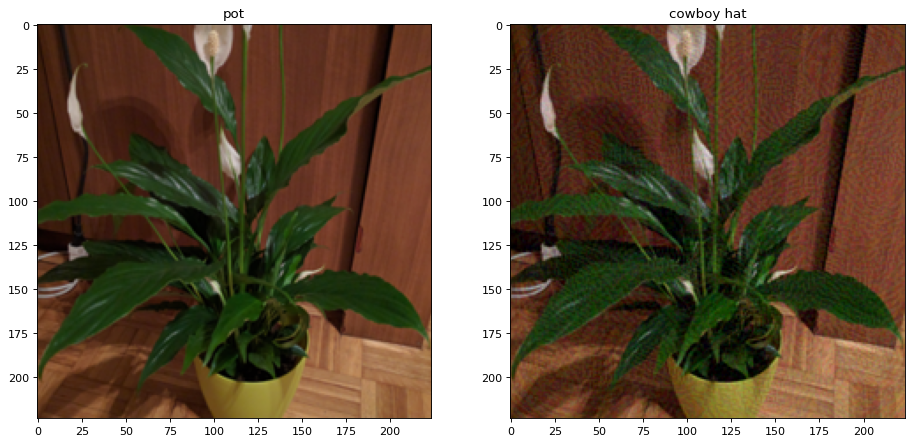

In [7]:
# Test the perturbation on the image
labels = open(os.path.join('python', 'data', 'labels.txt'), 'r').read().split('\n')

image_original = preprocess_image_batch([path_test_image], img_size=(256, 256), crop_size=(224, 224), color_mode="rgb")
label_original = np.argmax(f(image_original), axis=1).flatten()
str_label_original = labels[np.int(label_original)-1].split(',')[0]

# Clip the perturbation to make sure images fit in uint8
clipped_v = np.clip(undo_image_avg(image_original[0,:,:,:]+v[0,:,:,:]), 0, 255) - np.clip(undo_image_avg(image_original[0,:,:,:]), 0, 255)

image_perturbed = image_original + clipped_v[None, :, :, :]
label_perturbed = np.argmax(f(image_perturbed), axis=1).flatten()
str_label_perturbed = labels[np.int(label_perturbed)-1].split(',')[0]

# Show original and perturbed image
plt.figure(figsize=(14, 10), dpi=80)
plt.subplot(1, 2, 1)
plt.imshow(undo_image_avg(image_original[0, :, :, :]).astype(dtype='uint8'), interpolation=None)
plt.title(str_label_original)

plt.subplot(1, 2, 2)
plt.imshow(undo_image_avg(image_perturbed[0, :, :, :]).astype(dtype='uint8'), interpolation=None)
plt.title(str_label_perturbed)

plt.show()

In [8]:
tf_device.__exit__()